In [3]:
import csv
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras import layers, models

keras.__version__, K.tf.__version__

Using TensorFlow backend.


('2.2.0', '1.9.0')

## Load DTD for testing

In [4]:
def center_crop(img, side_length):
    '''Resize short side to side_length, then center square crop.'''
    h, w, _ = img.shape
    new_h, new_w = side_length, side_length
    if h > w:
        new_h = int(side_length*(h/w))
    else:
        new_w = int(side_length*(w/h))
    r_img = transform.resize(img, (new_h, new_w))
    
    h_offset = (new_h - side_length) // 2
    w_offset = (new_w - side_length) // 2
    
    return r_img[h_offset:h_offset+side_length,w_offset:w_offset+side_length]

In [5]:
dtd_dir = '/home/administrator/Dropbox/benchmark/dtd'
img_dir = dtd_dir+'/images/'

# just use the first split (of 10) for now
train_reader = csv.reader(open(dtd_dir+'/labels/train1.txt'))
train_list = [row[0] for row in train_reader]

val_reader = csv.reader(open(dtd_dir+'/labels/val1.txt'))
val_list = [row[0] for row in val_reader]

test_reader = csv.reader(open(dtd_dir+'/labels/test1.txt'))
test_list = [row[0] for row in test_reader]

len(train_list), len(val_list), len(test_list)

(1880, 1880, 1880)

In [6]:
classes = set([s.split('/')[0] for s in train_list])
classes = sorted(list(classes))
len(classes), classes

(47,
 ['banded',
  'blotchy',
  'braided',
  'bubbly',
  'bumpy',
  'chequered',
  'cobwebbed',
  'cracked',
  'crosshatched',
  'crystalline',
  'dotted',
  'fibrous',
  'flecked',
  'freckled',
  'frilly',
  'gauzy',
  'grid',
  'grooved',
  'honeycombed',
  'interlaced',
  'knitted',
  'lacelike',
  'lined',
  'marbled',
  'matted',
  'meshed',
  'paisley',
  'perforated',
  'pitted',
  'pleated',
  'polka-dotted',
  'porous',
  'potholed',
  'scaly',
  'smeared',
  'spiralled',
  'sprinkled',
  'stained',
  'stratified',
  'striped',
  'studded',
  'swirly',
  'veined',
  'waffled',
  'woven',
  'wrinkled',
  'zigzagged'])

In [7]:
def to_class(s):
    return classes.index(s.split('/')[0])

X_train = [center_crop(io.imread(img_dir+f), 448) for f in train_list]
y_train = [to_class(f) for f in train_list]

X_val = [center_crop(io.imread(img_dir+f), 448) for f in val_list]
y_val = [to_class(f) for f in val_list]

# Using train + val as train
X_train = np.array(X_train + X_val)
y_train = np.array(y_train + y_val)

X_test = np.array([center_crop(io.imread(img_dir+f), 448) for f in test_list])
y_test = np.array([to_class(f) for f in test_list])

/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## CNN Building

In [19]:
from texture.ops.bilinearpooling import pooling

In [14]:
def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              stride=1,
              dilation=1,
              name=None):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        stride: stride in `Conv2D`.
        dilation: dilation_rate in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = layers.Conv2D(
        filters, (num_row, num_col),
        strides=(stride,stride),
        padding=padding,
        dilation_rate=(dilation,dilation),
        use_bias=False,
        name=conv_name)(x)
    x = layers.BatchNormalization(axis=3, scale=False, name=bn_name)(x)
    x = layers.Activation('relu', name=name)(x)
    return x



In [39]:


input_image = layers.Input(shape=(448,448,3), name='input_layer')

# initial conv
x = layers.Conv2D(64, (7,7), strides=(2,2), padding='same')(input_image)
x = layers.MaxPool2D()(x)

# first wide block
c1 = conv2d_bn(x, 32, 1, 1, name='block1_1')
c3 = conv2d_bn(x, 32, 3, 3, name='block1_3')
c5 = conv2d_bn(x, 32, 3, 3, dilation=2, name='block1_5')
c7 = conv2d_bn(x, 32, 3, 3, dilation=3, name='block1_7')
c9 = conv2d_bn(x, 32, 3, 3, dilation=4, name='block1_9')
c11 = conv2d_bn(x, 32, 3, 3, dilation=5, name='block1_11')
c13 = conv2d_bn(x, 32, 3, 3, dilation=6, name='block1_13')

x = layers.Concatenate()([c1,c3,c5,c7,c9,c11,c13])
x = layers.MaxPool2D()(x)

# reduce and pool
pool1 = layers.Conv2D(64, (1,1), activation='relu', name='reduce_1')(x)
pool1 = layers.Lambda(pooling, name='pooling_1')([pool1, pool1])

# next wide block
c1 = conv2d_bn(x, 32, 1, 1, name='block2_1')
c3 = conv2d_bn(x, 32, 3, 3, name='block2_3')
c5 = conv2d_bn(x, 32, 3, 3, dilation=2, name='block2_5')
c7 = conv2d_bn(x, 32, 3, 3, dilation=3, name='block2_7')
c9 = conv2d_bn(x, 32, 3, 3, dilation=4, name='block2_9')
c11 = conv2d_bn(x, 32, 3, 3, dilation=5, name='block2_11')
c13 = conv2d_bn(x, 32, 3, 3, dilation=6, name='block2_13')

x = layers.Concatenate()([c1,c3,c5,c7,c9,c11,c13])
x = layers.MaxPool2D()(x)

# reduce and pool
pool2 = layers.Conv2D(64, (1,1), activation='relu', name='reduce_2')(x)
pool2 = layers.Lambda(pooling, name='pooling_2')([pool2,pool2])

# classifier
pool1 = layers.Flatten()(pool1)
pool2 = layers.Flatten()(pool2)

pooled_feat = layers.Concatenate()([pool1,pool2])
preds = layers.Dense(47, activation='softmax')(pooled_feat)

model = models.Model(inputs=input_image, outputs=preds)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 224, 224, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
block1_1_conv (Conv2D)          (None, 112, 112, 32) 2048        max_pooling2d_3[0][0]            
__________________________________________________________________________________________________
block1_3_c

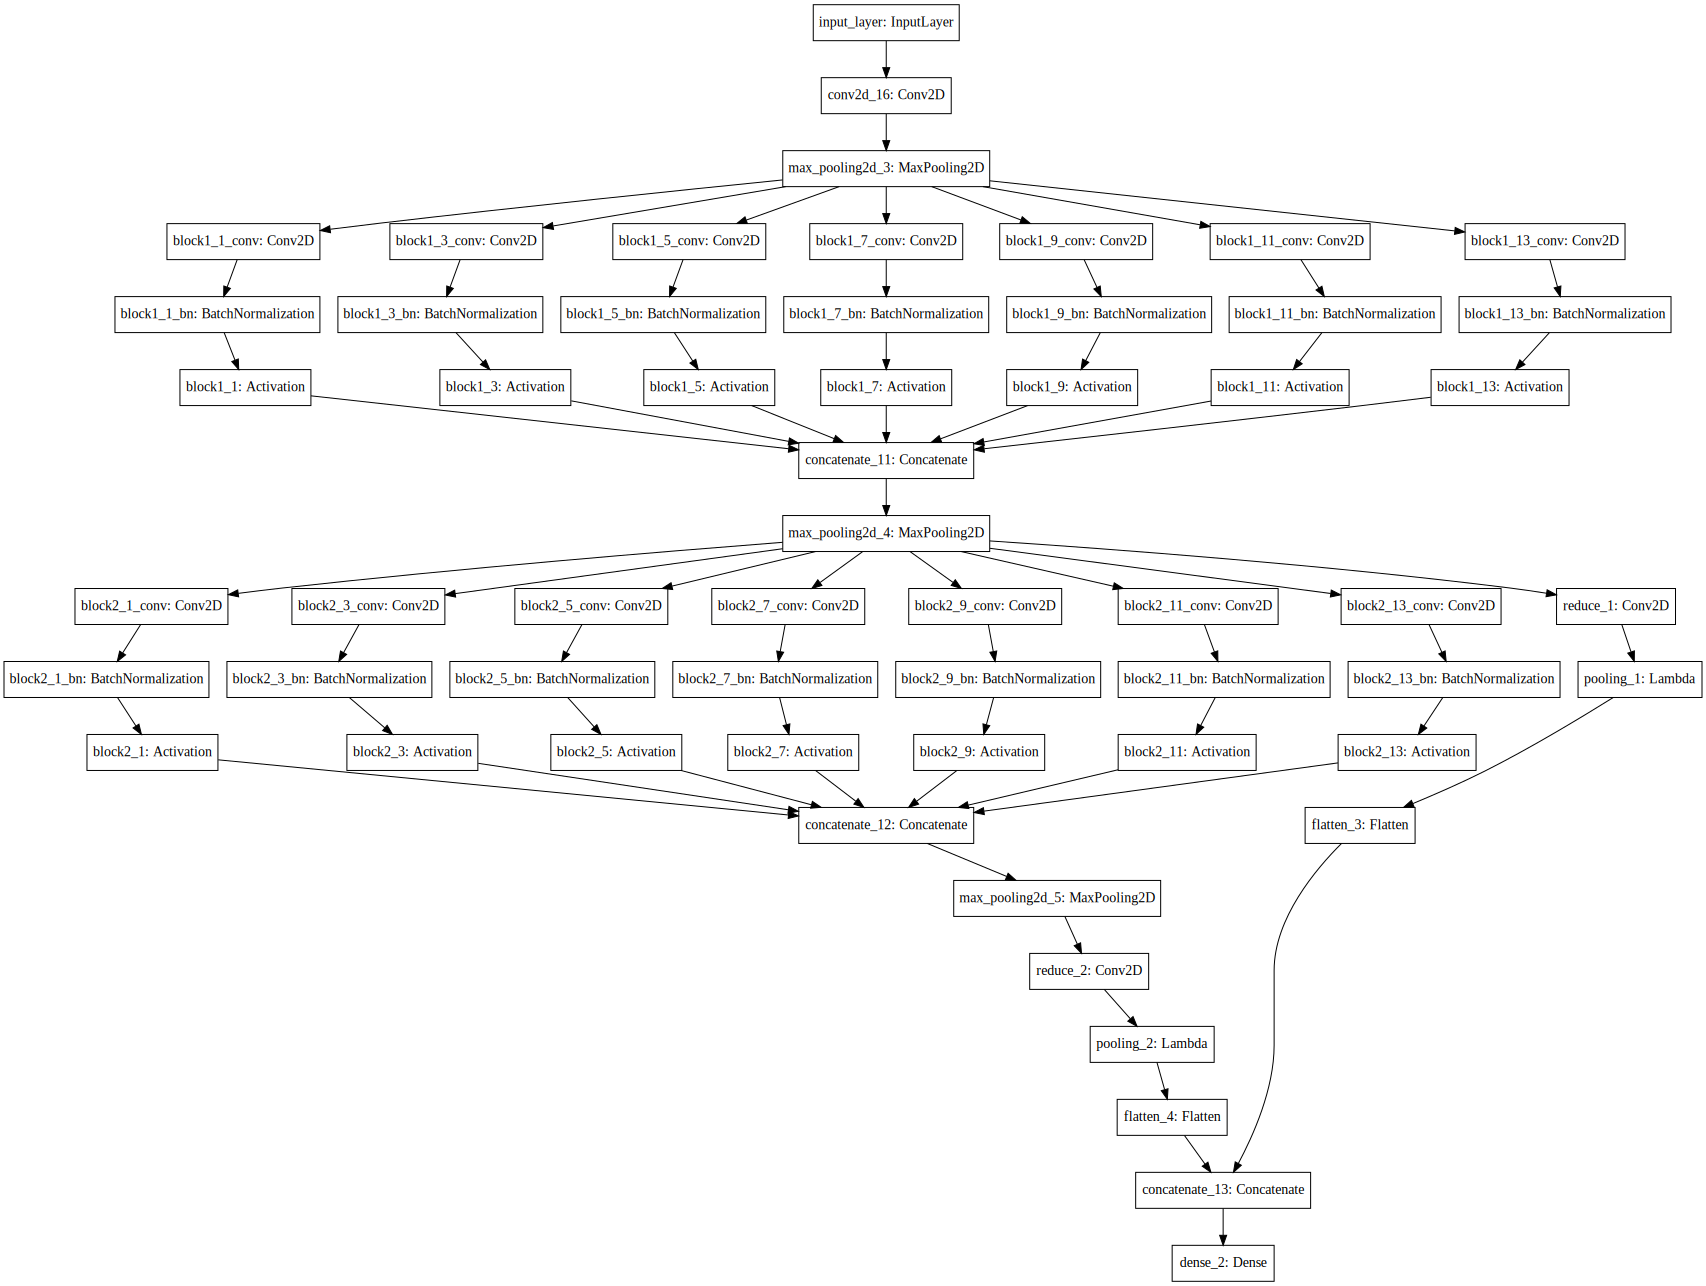

In [40]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Test training

In [29]:
from keras import utils
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
train_gen = ImageDataGenerator(width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=5.0,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              vertical_flip=True)

val_gen = ImageDataGenerator()
train_gen.fit(X_train)
val_gen.fit(X_test)

In [31]:
y_train = utils.to_categorical(y_train, 47)
y_test = utils.to_categorical(y_test, 47)

In [41]:
epochs = 300
batch_size = 16
#steps_per = len(X_train)//batch_size
#total_steps = steps_per*epochs

# adam.lr will be overrridden by clr.lr
#clr = CyclicLR(base_lr=0.0005, max_lr=0.05, step_size=total_steps)

adam = optimizers.Adam()
model.compile(optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

dbox_path = '/home/administrator/Dropbox/benchmark/benchmark_models/'
CHKPT_PATH = dbox_path+'textureNet_2block.hdf5'
checkpoint = ModelCheckpoint(CHKPT_PATH, monitor='val_loss', save_best_only=True)
#early_stop = EarlyStopping(monitor='val_loss', patience=50)

train_flow = train_gen.flow(X_train, y_train, batch_size=batch_size)
test_flow = val_gen.flow(X_test, y_test, batch_size=batch_size)

# Training
history = model.fit_generator(train_flow,
                        steps_per_epoch=len(X_train)//batch_size,
                        validation_data=test_flow,
                        validation_steps=len(X_test)//batch_size,
                        callbacks=[checkpoint], verbose=1, epochs=epochs)

Epoch 1/300
235/235 [==============================] - 125s 534ms/step - loss: 3.8063 - acc: 0.0641 - val_loss: 3.9274 - val_acc: 0.0507
Epoch 2/300
235/235 [==============================] - 119s 507ms/step - loss: 3.4955 - acc: 0.1176 - val_loss: 3.9026 - val_acc: 0.0582
Epoch 3/300
235/235 [==============================] - 118s 503ms/step - loss: 3.3464 - acc: 0.1418 - val_loss: 4.0238 - val_acc: 0.0678
Epoch 4/300
235/235 [==============================] - 120s 509ms/step - loss: 3.2198 - acc: 0.1715 - val_loss: 3.7356 - val_acc: 0.0903
Epoch 5/300
235/235 [==============================] - 120s 509ms/step - loss: 3.1361 - acc: 0.1912 - val_loss: 4.0315 - val_acc: 0.0593
Epoch 6/300
235/235 [==============================] - 119s 508ms/step - loss: 3.0577 - acc: 0.2173 - val_loss: 3.5449 - val_acc: 0.0988
Epoch 7/300
235/235 [==============================] - 119s 507ms/step - loss: 3.0256 - acc: 0.2157 - val_loss: 3.7800 - val_acc: 0.0967
Epoch 8/300
235/235 [====================

235/235 [==============================] - 118s 502ms/step - loss: 1.6024 - acc: 0.5535 - val_loss: 2.8480 - val_acc: 0.3040
Epoch 61/300
235/235 [==============================] - 118s 501ms/step - loss: 1.6370 - acc: 0.5418 - val_loss: 4.3802 - val_acc: 0.1517
Epoch 62/300
235/235 [==============================] - 118s 503ms/step - loss: 1.6685 - acc: 0.5362 - val_loss: 2.8385 - val_acc: 0.3013
Epoch 63/300
235/235 [==============================] - 118s 502ms/step - loss: 1.7610 - acc: 0.5019 - val_loss: 3.1211 - val_acc: 0.2580
Epoch 64/300
235/235 [==============================] - 119s 506ms/step - loss: 1.6514 - acc: 0.5378 - val_loss: 2.7214 - val_acc: 0.3333
Epoch 65/300
235/235 [==============================] - 118s 504ms/step - loss: 1.6898 - acc: 0.5104 - val_loss: 2.8355 - val_acc: 0.3120
Epoch 66/300
235/235 [==============================] - 118s 502ms/step - loss: 1.6035 - acc: 0.5503 - val_loss: 3.6920 - val_acc: 0.1896
Epoch 67/300
235/235 [=========================

235/235 [==============================] - 118s 500ms/step - loss: 1.0796 - acc: 0.6848 - val_loss: 2.7665 - val_acc: 0.3446
Epoch 120/300
235/235 [==============================] - 118s 501ms/step - loss: 1.0415 - acc: 0.6939 - val_loss: 2.7321 - val_acc: 0.3526
Epoch 121/300
235/235 [==============================] - 118s 503ms/step - loss: 1.0875 - acc: 0.6862 - val_loss: 6.1859 - val_acc: 0.0625
Epoch 122/300
235/235 [==============================] - 118s 501ms/step - loss: 1.7999 - acc: 0.4944 - val_loss: 2.9571 - val_acc: 0.3210
Epoch 123/300
235/235 [==============================] - 118s 503ms/step - loss: 1.3981 - acc: 0.5926 - val_loss: 3.0620 - val_acc: 0.2991
Epoch 124/300
235/235 [==============================] - 118s 502ms/step - loss: 1.1891 - acc: 0.6606 - val_loss: 3.0227 - val_acc: 0.3125
Epoch 125/300
235/235 [==============================] - 118s 502ms/step - loss: 1.1159 - acc: 0.6697 - val_loss: 2.8565 - val_acc: 0.3462
Epoch 126/300
235/235 [==================

235/235 [==============================] - 118s 502ms/step - loss: 0.8644 - acc: 0.7444 - val_loss: 2.8255 - val_acc: 0.3729
Epoch 179/300
235/235 [==============================] - 118s 503ms/step - loss: 0.8072 - acc: 0.7604 - val_loss: 2.8388 - val_acc: 0.3552
Epoch 180/300
235/235 [==============================] - 118s 502ms/step - loss: 0.7555 - acc: 0.7824 - val_loss: 3.0382 - val_acc: 0.3510
Epoch 181/300
235/235 [==============================] - 118s 502ms/step - loss: 0.7385 - acc: 0.7838 - val_loss: 2.9575 - val_acc: 0.3494
Epoch 182/300
235/235 [==============================] - 118s 502ms/step - loss: 0.7533 - acc: 0.7766 - val_loss: 2.9357 - val_acc: 0.3665
Epoch 183/300
235/235 [==============================] - 118s 502ms/step - loss: 0.7160 - acc: 0.7926 - val_loss: 2.8937 - val_acc: 0.3766
Epoch 184/300
235/235 [==============================] - 118s 502ms/step - loss: 0.7268 - acc: 0.7822 - val_loss: 2.8679 - val_acc: 0.3729
Epoch 185/300
235/235 [==================

235/235 [==============================] - 118s 503ms/step - loss: 0.5390 - acc: 0.8463 - val_loss: 2.9262 - val_acc: 0.3889
Epoch 238/300
235/235 [==============================] - 118s 503ms/step - loss: 0.5214 - acc: 0.8449 - val_loss: 2.8960 - val_acc: 0.3958
Epoch 239/300
235/235 [==============================] - 118s 502ms/step - loss: 0.6514 - acc: 0.8059 - val_loss: 3.0530 - val_acc: 0.3649
Epoch 240/300
235/235 [==============================] - 118s 501ms/step - loss: 0.5386 - acc: 0.8420 - val_loss: 2.8896 - val_acc: 0.3921
Epoch 241/300
235/235 [==============================] - 118s 504ms/step - loss: 0.5325 - acc: 0.8434 - val_loss: 2.9667 - val_acc: 0.3878
Epoch 242/300
235/235 [==============================] - 118s 502ms/step - loss: 0.5101 - acc: 0.8545 - val_loss: 2.9925 - val_acc: 0.3702
Epoch 243/300
235/235 [==============================] - 118s 502ms/step - loss: 0.7253 - acc: 0.7848 - val_loss: 2.9785 - val_acc: 0.3681
Epoch 244/300
235/235 [==================

235/235 [==============================] - 118s 504ms/step - loss: 0.4691 - acc: 0.8577 - val_loss: 3.1985 - val_acc: 0.3766
Epoch 297/300
235/235 [==============================] - 118s 502ms/step - loss: 0.4289 - acc: 0.8718 - val_loss: 3.0333 - val_acc: 0.4017
Epoch 298/300
235/235 [==============================] - 118s 502ms/step - loss: 0.4716 - acc: 0.8556 - val_loss: 3.1909 - val_acc: 0.3552
Epoch 299/300
235/235 [==============================] - 118s 502ms/step - loss: 0.4925 - acc: 0.8559 - val_loss: 3.0694 - val_acc: 0.3868
Epoch 300/300
235/235 [==============================] - 118s 501ms/step - loss: 0.4919 - acc: 0.8524 - val_loss: 3.2323 - val_acc: 0.3590


In [ ]:
def conv_branch(x, receptive_field, filters, name):
    assert receptive_field % 2 == 1, 'must be odd'
    if receptive_field == 1:
        return conv2d_bn(x, filters, 1, 1, name=name)
    else:
        dilation = (receptive_field-1)//2
        return conv2d_bn(x, filters, 3, 3, dilation=dilation, name=name)


def wide_texture_net(n_classes,
                     n_blocks,
                     input_shape,
                     branches=[1,3,5,7,9,11,13],
                     filters_per_branch=32,
                     aux_filters=64,
                     pooling_method='bilinear'):
    
    input_image = layers.Input(shape=input_shape, name='input_layer')

    # initial conv + downsample
    x = layers.Conv2D(64, (7,7), strides=(2,2), padding='same')(input_image)
    x = layers.MaxPool2D()(x)
    
    aux_outs = []
    for i in range(n_blocks):
        branch_out = []
        for r in branches:
            name = 'block'+str(i)+'_r'+str(r)
            branch_out.append(conv_branch(x, r, filters_per_branch, name))
        x = layers.Concatenate()(branch_out)
        x = layers.MaxPool2D()(x)
        aux = layers.Conv2D(aux_filters, (1,1), activation='relu', 
                            name='reduce'+str(i))(x)
        aux = layers.Lambda(pooling, name='pooling'+str(i))([aux, aux])
        aux_outs.append(layers.Flatten()(aux))
        
    pooled_feats = layers.Concatenate()(aux_outs)
    preds = layers.Dense(n_classes, activation='softmax')(pooled_feat)

    model = models.Model(inputs=input_image, outputs=preds)

    return model